# Tutorial 2. Advanced capabilities of the MeasurementControl

Following this Tutorial requires familiarity with the **core concepts** of quantify, we **highly recommended** to consult the (short) *User guide* before proceeding (see quantify documentation). If you have some difficulties following the tutorial it might be worth reviewing the *User guide*!

We **highly recommended** to begin with Tutorial 1 before proceeding.

In this tutorial, we will explore the more advanced features of quantify. By the end of this tutorial, we will have covered:

- Using hardware to drive experiments
- Software averaging
- Safely interrupting a running experiment

In [2]:
import time
import random

import numpy as np
import xarray as xr
import scipy
from qcodes import ManualParameter, Parameter
%matplotlib inline
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

In [3]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

## A 1D hard(ware) controlled loop: Resonator Spectroscopy
### Defining a simple model

In this example, we want to find the resonance of some device. We expect to find it's resonance somewhere in the low 6GHz range, but manufacturing imperfections makes it impossible to know exactly without inspection.

We first create `freq`: a `Settable` with a `QCodes.Parameter` (a `ManualParameter`) to represent the frequency of the signal probing the resonator, followed by a custom `Gettable` to mock (i.e. emulate) the resonating material. The Resonator will return a Lorentzian shape centred on the resonant frequency. Our `Gettable` will read the setpoints from `freq`, in this case a 1D array.

Note that the `Resonator` `Gettable` has a new field `soft` set to `False`. This property informs the MeasurementControl that it will not be in charge of iterating over the setpoints, instead the `Resonator` manages its own data acquisition.

In [74]:
# Note that in an actual experimental setup `freq` will be a QCoDeS parameter
# contained in a QCoDeS `Instrument`
freq = ManualParameter(name='frequency', unit='Hz', label='Frequency')
# NB a QCoDeS parameter can be of many different types, e.g. floats, integers
# but it can also be, for example, and array of floats. This is the case in a hard(ware) controlled loop

# model of the frequency response
def lorenz(amplitude, fwhm, x, x_0):
    return (amplitude * ((fwhm / 2.) ** 2) / ((x - x_0) ** 2 + (fwhm / 2.) ** 2))


class Resonator:
    def __init__(self):
        self.name = 'resonator'
        self.unit = 'V'
        self.label = 'Amplitude'
        self.soft = False
        
        # variables specific to the emulated material
        self.test_resonance = 6.0001048e9 # in Hz
        self.test_width = 300 # FWHM in Hz

    def get(self):
        print("The `get` method of the `Gettable` was called")
        # Emulation of the frequency response
        # NB in a physical instrument there will be no `freq()` call in this method
        return 1-np.array(list(map(lambda x: lorenz(1, self.test_width, x, self.test_resonance), freq())))


### Running the experiment
Just like our `soft` 1D loop, our complete experiment is expressed in just four lines of code.

The main difference is defining the `soft` property of our `Gettable` to False. The `MeasurementControl` will detect these settings and run in the appropriate`hard` mode.

In [58]:
# At this point the `freq` parameter is empty
print(freq())

None


In [59]:
MC.settables(freq)
MC.setpoints(np.arange(6.0001e9, 6.00011e9, 5))
MC.gettables(Resonator())
dset = MC.run()

The `get` method of the `Gettable` was called
 100% completed 	elapsed time: 0.5s 	time left: 0.0s


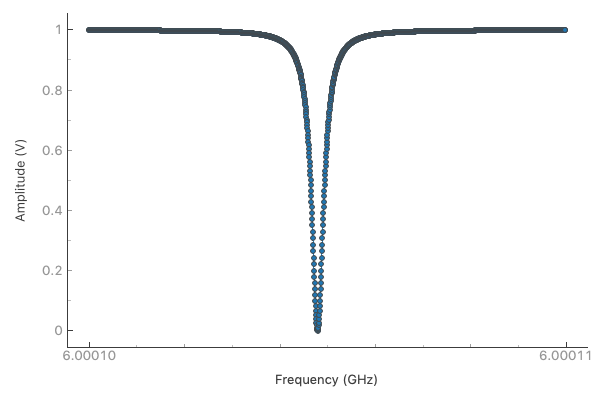

In [60]:
plotmon.main_QtPlot

As expected, we find a Lorentzian spike in the readout at the resonant frequency, finding the peak of which is trivial.

Note that the `get` method of the `Resonator` `Gettable` was called only a single time since the Measurement Control is not in charge of the iteration over the setpoints. Internally, the Measurement Control limits itself to *setting* the `setpoints` in the `Settable`, all at once. As we can ispect, the `freq` parameter is not empty anymore:

In [61]:
print(freq())

[6.00010000e+09 6.00010000e+09 6.00010001e+09 ... 6.00010998e+09
 6.00010999e+09 6.00011000e+09]


## Software Averaging: T1 Experiment
In many cases it is desirable to run an experiment many times and average the result, such as when filtering noise on instruments or measuring probability. For this purpose, the MeasurementControl provides the `soft_avg` parameter. If set to *x*, the experiment will run *x* times whilst performing a running average over each setpoint.

In this example, we want to find the relaxation time (aka T1) of a Qubit. As before, we define a `Settable` and `Gettable`, representing the varying timescales we will probe through and a mock Qubit emulated in software. The mock Qubit returns the expected decay sweep but with a small amount of noise (simulating the variable qubit characteristics). We set the qubit's T1 to 60ms - obviously in a real experiment we would be trying to determine this, but for this ilustration purpuses in this tutorial we set it to a known value to verify our fit later on.

Note that in this example MC is still running in the `hard` mode.

In [66]:
MC.soft_avg(1)

In [69]:
# T1 experiment decay model
def decay(t, tau):
    return np.exp(-t/tau)

time_par = ManualParameter(name='time', unit='s', label='Measurement Time')

class MockQubit:
    def __init__(self):
        self.name = 'qubit'
        self.unit = '%'
        self.label = 'High V'
        self.soft = False # This is still a hard(ware) controlled loop!
        
        self.delay = 0.05 # sleep time in secs
        self.test_relaxation_time = 60e-6

    def get(self):
        time.sleep(self.delay) # adds a delay to be able to appreciate the data aquisition
        return np.array(list(map(lambda x: decay(x, self.test_relaxation_time) + random.uniform(-0.1, 0.1), time_par())))


We will then sweep through 0 to 300ms, getting our data from the mock Qubit. Let's first observe what a single run looks like:

 100% completed 	elapsed time: 0.5s 	time left: 0.0s


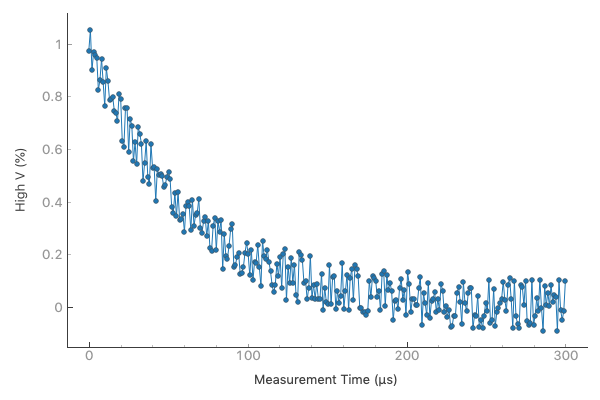

In [70]:
MC.settables(time_par)
MC.setpoints(np.linspace(0.0, 300.0e-6, 300))
MC.gettables(MockQubit())
MC.run('noisy')
plotmon.main_QtPlot

Alas, the noise in the signal has made this result unusable! Let's set the `soft_avg` parameter of the MeasurementControl to 100, averaging the results and hopefully filtering out the noise.

 100% completed 	elapsed time: 8.8s 	time left: 0.0s


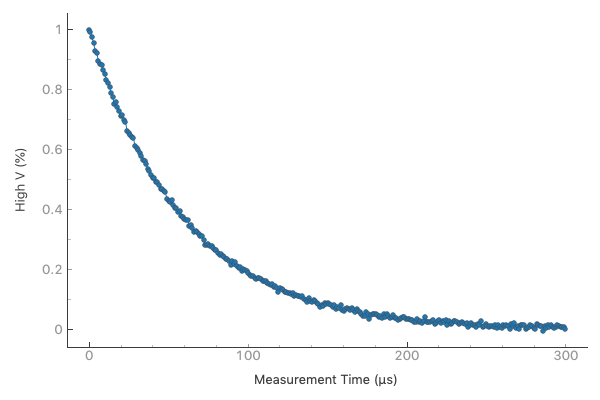

In [72]:
MC.soft_avg(100)
dset = MC.run('averaged')
plotmon.main_QtPlot

Success! We now have a smooth decay curve based on the characteristics of our qubit. All that remains is to run a fit against the expected values and we can solve for T1.

{'tau': 6.011219856886036e-05}

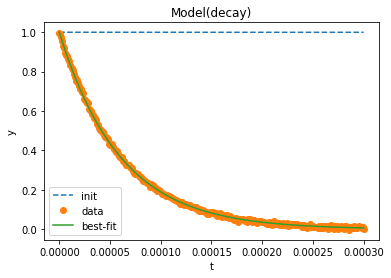

In [73]:
from lmfit import Model

model = Model(decay, independent_vars=['t'])
fit_res = model.fit(dset['y0'].values, t=dset['x0'].values, tau=1)

fit_res.plot_fit(show_init=True)
fit_res.values